In [123]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import json
import sys
sys.path.append("..")
import util    # helper functions

import warnings
warnings.filterwarnings("ignore")

In [154]:
# Get relevant secrets and variables

print("Connecting to Hopsworks...")
hopsworks_key = os.getenv("HOPSWORKS_API_KEY") 
hopsworks_project_name = os.getenv("HOPSWORKS_PROJECT")
project = hopsworks.login(project=hopsworks_project_name, api_key_value=hopsworks_key) 
fs = project.get_feature_store()

with open("../city_config/gothenburg_femman.json") as f:
    city_config = json.load(f)

country = city_config["city_name"]
city = city_config["country_name"]
street = city_config["street_name"]
LAT = city_config["city_lat"]
LON = city_config["city_lon"]
SENSOR = city_config["sensors"][0] 
FG_VERSIONS = city_config["fg_versions"]

feature_view = city_config["feature_view"]
feature_view_name = feature_view['name']
feature_view_version = feature_view['version']

Connecting to Hopsworks...
2025-11-13 10:00:46,024 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-13 10:00:46,031 INFO: Initializing external client
2025-11-13 10:00:46,031 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-13 10:00:47,250 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271989


In [125]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=FG_VERSIONS["air_quality"],
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=FG_VERSIONS["weather"],
)

forecast_fg = fs.get_feature_group(            # keeping forecast features separate
    name='weather_forecast_features',
    version=FG_VERSIONS["weather_forecast_features"],
)

In [126]:
air_quality_df = air_quality_fg.read()

# Sort by date to ensure temporal order
air_quality_df = air_quality_df.sort_values(by=['city', 'street', 'date'])

# Create lag features
for lag in [1, 2, 3]:
    air_quality_df[f'pm2_5_lag_{lag}'] = air_quality_df.groupby(['city', 'street'])['pm2_5'].shift(lag)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


In [127]:
# New feature group for comparing lag features
lagged_fg = fs.get_or_create_feature_group(
    name="air_quality_lagged",
    description="Air quality data with lag features (1, 2, 3 days)",
    version=1,
    primary_key=['city', 'date', 'street'],
    event_time='date',
)

lagged_fg.insert(air_quality_df)


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1271989/fs/1258587/fg/1710416


Uploading Dataframe: 100.00% |██████████| Rows 1846/1846 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271989/jobs/named/air_quality_lagged_1_offline_fg_materialization/executions


(Job('air_quality_lagged_1_offline_fg_materialization', 'SPARK'), None)

In [152]:
# Select features for training data.
selected_features = lagged_fg.select(['pm2_5', 'pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3', 'date']).join(weather_fg.select_features(), on=['city', 'street', 'date'])
# selected_features = air_quality_fg.select(['pm2_5', 'date']).join(weather_fg.select_features(), on=['city', 'street', 'date'])

2025-11-13 10:00:33,975 INFO: Using ['wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'temperature_2m_max', 'country'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [153]:
selected_features

In [155]:
feature_view = fs.get_or_create_feature_view(
    name=feature_view_name,
    description="Weather features with air quality (pm2.5) as the target",
    version=feature_view_version,
    labels=['pm2_5'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1271989/fs/1258587/fv/air_quality_fv/version/2


In [156]:
# Time-series split of train/test data
start_date_test_data = "2025-05-01"

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [157]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 


In [158]:
X_train

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,date,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,country
0,16.0,15.0,NaN,2019-11-08 00:00:00+00:00,18.7,36.0,107,7.3,Sweden
1,32.0,30.0,38.0,2019-11-15 00:00:00+00:00,20.3,38.9,79,6.1,Sweden
2,16.0,11.0,28.0,2019-12-11 00:00:00+00:00,37.8,82.1,194,6.8,Sweden
3,21.0,64.0,21.0,2020-01-04 00:00:00+00:00,43.6,90.7,299,5.1,Sweden
4,13.0,21.0,64.0,2020-01-05 00:00:00+00:00,24.7,47.5,226,5.5,Sweden
...,...,...,...,...,...,...,...,...,...
1825,26.0,24.0,26.0,2025-02-02 00:00:00+00:00,9.7,18.0,139,1.6,Sweden
1826,40.0,17.0,31.0,2025-02-09 00:00:00+00:00,14.8,33.8,49,2.3,Sweden
1827,46.0,23.0,39.0,2025-02-15 00:00:00+00:00,21.3,46.4,52,0.8,Sweden
1828,44.0,32.0,25.0,2025-03-03 00:00:00+00:00,28.8,60.1,256,8.2,Sweden


In [159]:
# Drop first few NaN rows from lagging from the train set (but not in test set to not shorten the eval period)
valid_idx = X_train.dropna(subset=['pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3']).index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

In [160]:
# X_features = X_train.drop(columns=['date', 'country', 'street'])
# X_test_features = X_test.drop(columns=['date', 'country', 'street'])
X_features = X_train.drop(columns=['date','country'])
X_test_features = X_test.drop(columns=['date', 'country'])

In [161]:
X_features

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max
1,32.0,30.0,38.0,20.3,38.9,79,6.1
2,16.0,11.0,28.0,37.8,82.1,194,6.8
3,21.0,64.0,21.0,43.6,90.7,299,5.1
4,13.0,21.0,64.0,24.7,47.5,226,5.5
5,25.0,49.0,28.0,20.6,38.2,234,4.4
...,...,...,...,...,...,...,...
1825,26.0,24.0,26.0,9.7,18.0,139,1.6
1826,40.0,17.0,31.0,14.8,33.8,49,2.3
1827,46.0,23.0,39.0,21.3,46.4,52,0.8
1828,44.0,32.0,25.0,28.8,60.1,256,8.2


In [162]:
y_train

,pm2_5
1,28.0
2,27.0
3,13.0
4,19.0
5,14.0
...,...
1825,34.0
1826,60.0
1827,18.0
1828,49.0


In [163]:
# Hyperparameter tuning:
# Define the hyperparameter grid
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'n_estimators': [100, 300, 500],
    'gamma': [0, 1, 5]
}

# Create the XGBoost model object
xgb_model = XGBRegressor()

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,        # number of random combinations
    cv=5,
    scoring='neg_mean_squared_error',  # regression metric
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_features, y_train)

best_params = random_search.best_params_ 
print("Best hyperparameters:", best_params)
print("Best MSE:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.

In [164]:
# Modelling

# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(**best_params, random_state=42)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [165]:
# Forward-fill NaNs using previous day's value
X_test = X_test.fillna(method='ffill')

In [166]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 77.58194020988054
R squared: 0.3588686247416235


In [167]:
df = y_test
df['predicted_pm25'] = y_pred

In [168]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm2_5,predicted_pm25,date
1588,54.0,33.470070,2025-05-01 00:00:00+00:00
786,47.0,39.015644,2025-05-02 00:00:00+00:00
1589,24.0,27.155537,2025-05-03 00:00:00+00:00
556,9.0,19.910461,2025-05-04 00:00:00+00:00
1830,20.0,16.956522,2025-05-05 00:00:00+00:00


In [169]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "../air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

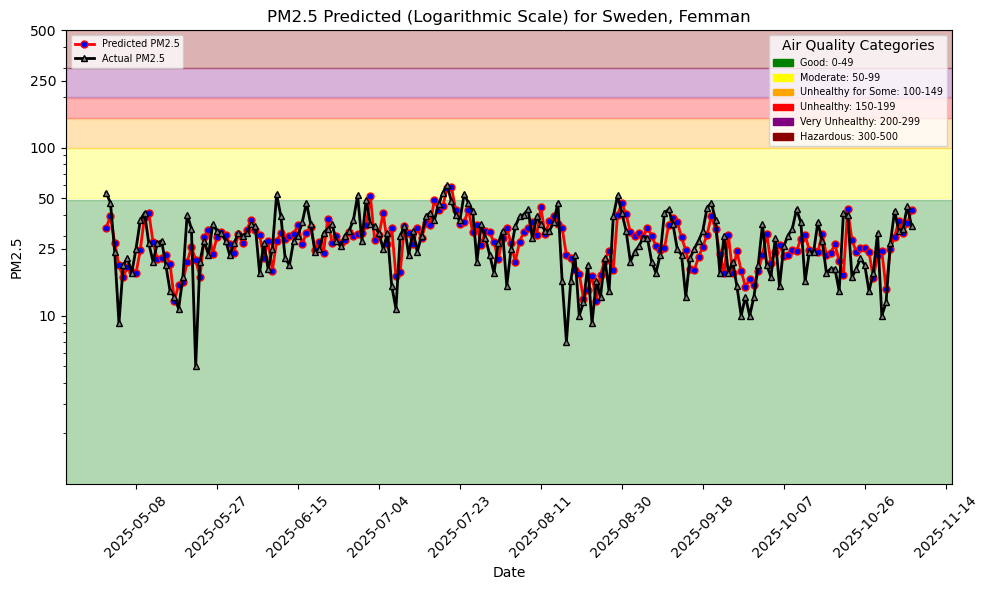

In [170]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

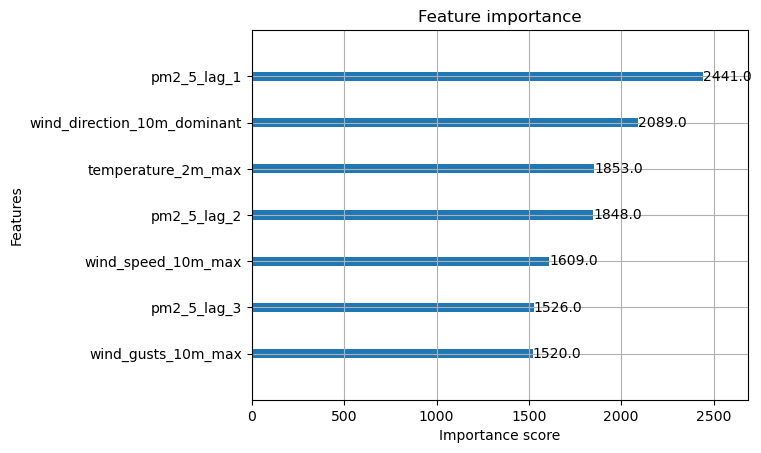

In [171]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [172]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [173]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [174]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_with_lag_features_2", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/model.json: 0…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/featur…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_h…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/daily_plots/f…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/daily_plots/h…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271989/models/air_quality_xgboost_model_with_lag_features_2/1


Model(name: 'air_quality_xgboost_model_with_lag_features_2', version: 1)